In [1]:
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
from time import time
import scipy as sp
from scipy import interpolate
from math import exp
from random import randrange, random, choice

In [1]:

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

"ln" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7416 sha256=11c039dc1b390cf92b782235bd5117d514591c04eee178d2c172b4b16871a62f
  Stored in directory: C:\Users\Alexander\AppData\Local\pip\Cache\wheels\3d\77\07\80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
  Created wheel for humanize: filename=humanize-0.5.1-cp37-none-any.whl size=17908 sha256=0796daf305426e929e4289878574511a462484b66f65f02b3d845fff61b16d12
  Stored in directory: C:\Users\Alexander\AppData\Local\pip\Cache\wheels\69\86\6c\f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 18.5 GB  | Proc size: 54.0 MB
GPU RAM Free: 230MB | Used: 7962MB | Util  97% | Total 8192MB


## Surface and volume reinforced random walk simulation script

In [2]:
def simulate(aa, bb, N=10000):
    w = np.array([0, 1, 0], dtype = np.int32)
    s = np.array([0, -1, 0], dtype = np.int32)
    d = np.array([1, 0, 0], dtype = np.int32)
    a = np.array([-1, 0, 0], dtype = np.int32)
    e = np.array([0, 0, 1], dtype = np.int32)
    q = np.array([0, 0, -1], dtype = np.int32)

    class NDSparseLattice:
        def __init__(self):
            self.elements = {}

        def addValue(self, tuple, value):
            self.elements[tuple] = value

        def readValue(self, tuple):
            try:
                value = self.elements[tuple]
            except KeyError:
                # could also be 0.0 if using floats...
                value = 1.0
            return value

    def get_near(lattice, pos):
        n_w = lattice.readValue((pos[0], pos[1]+1, pos[2]))
        n_s = lattice.readValue((pos[0], pos[1]-1, pos[2]))
        n_d = lattice.readValue((pos[0]+1, pos[1], pos[2]))
        n_a = lattice.readValue((pos[0]-1, pos[1], pos[2]))
        n_e = lattice.readValue((pos[0], pos[1], pos[2]+1))
        n_q = lattice.readValue((pos[0], pos[1], pos[2]-1))
        return [n_w, n_s, n_d, n_a, n_e, n_q]

    def number_of_zero_neib(lattice, pos):
        if lattice.readValue((pos[0], pos[1], pos[2])) == 0:
            return 0
        else:
            count = 0
            array = get_near(lattice, pos)
            for item in array:
                if item == 0:
                    count = count+1
            return count+1

    def update_lattice(lattice, pos):
        lattice.addValue((pos[0], pos[1], pos[2]), 0)
        lattice.addValue((pos[0], pos[1]+1, pos[2]), number_of_zero_neib(lattice, pos+w))
        lattice.addValue((pos[0], pos[1]-1, pos[2]), number_of_zero_neib(lattice, pos+s))
        lattice.addValue((pos[0]+1, pos[1], pos[2]), number_of_zero_neib(lattice, pos+d))
        lattice.addValue((pos[0]-1, pos[1], pos[2]), number_of_zero_neib(lattice, pos+a))
        lattice.addValue((pos[0], pos[1], pos[2]+1), number_of_zero_neib(lattice, pos+e))
        lattice.addValue((pos[0], pos[1], pos[2]-1), number_of_zero_neib(lattice, pos+q))
        return lattice


    def weight(x, aa, bb):
        if x==0:
            return aa
        elif x==2:
            return 1
        elif x==1:
            print('Error')
            raise TypeError
        else:
            return bb

    def get_prob(lattice, pos, aa, bb):
        near = get_near(lattice, pos)
        norm = sum(near)
        probs = [weight(_, aa, bb) for _ in near]
        norm = sum(probs)
        probs_normed = [_/norm for _ in probs]
        return probs_normed

    def get_next_pos():
        symbol = np.random.choice(['w', 's', 'd', 'a', 'e', 'q'], p = get_prob(lattice, pos, aa, bb))
        if symbol == 'w':
            return w
        if symbol == 's':
            return s
        if symbol == 'd':
            return d
        if symbol == 'a':
            return a
        if symbol == 'e':
            return e
        if symbol == 'q':
            return q


    lattice = NDSparseLattice()
    pos = np.array([0,0,0], dtype=np.int32)
    lattice = update_lattice(lattice, pos)
    visited = []

    for _ in range(N):
        visited.append(list(pos))
        pos = pos +  get_next_pos()
        lattice = update_lattice(lattice, pos)
    return np.array(visited)

def simulate_vector(vector, N=1000):
    return simulate(vector[0], vector[1], N=N)

## Generate random walk trajectories

In [6]:
NUMBER_OF_TRAJECTORIES = 30000
PARAMETERS_SCALE = 10
LENGTH_OF_POLYMER_CHAIN = 500

# generate random array of model parameters
random_coords = np.exp(np.random.uniform(-PARAMETERS_SCALE, 
                                         PARAMETERS_SCALE, 
                                         (NUMBER_OF_TRAJECTORIES, 2)))

data_container = np.zeros((random_coords.shape[0], LENGTH_OF_POLYMER_CHAIN, 3), dtype=int)

from progressbar import ProgressBar
pbar = ProgressBar()

for _ in pbar(range(data_container.shape[0])):
    data_container[_] = np.diff(simulate_vector(random_coords[_], N=LENGTH_OF_POLYMER_CHAIN+1), axis=0)

100% |########################################################################|


In [63]:
np.save('data_container',data_container)
np.save('random_coords',random_coords)

In [3]:
data_container = np.load('data_container.npy')
random_coords = np.load('random_coords.npy')

## Obtain phase diagram from raw trajectories. Embeddings method.

In [4]:
flattened_data_container = data_container.reshape(data_container.shape[0], -1)

In [8]:
%%time
import umap
from sklearn.datasets import load_digits

embedding = umap.UMAP(verbose=True).fit_transform(flattened_data_container)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Tue Nov 12 01:11:00 2019 Finding Nearest Neighbors
Tue Nov 12 01:11:00 2019 Building RP forest with 14 trees


C:\deeplearning\envs\PythonGPU\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\deeplearning\envs\PythonGPU\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
C:\deeplearning\envs\PythonGPU\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\deeplearning\envs\PythonGPU\lib\site-packages\umap\rp_tree.

Tue Nov 12 01:11:04 2019 NN descent for 15 iterations


C:\deeplearning\envs\PythonGPU\lib\site-packages\umap\nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\deeplearning\envs\PythonGPU\lib\site-packages\umap\utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
C:\deeplearning\envs\PythonGPU\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\deeplearning\envs\

	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	 8  /  15
	 9  /  15
Tue Nov 12 01:11:21 2019 Finished Nearest Neighbor Search
Tue Nov 12 01:11:24 2019 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Nov 12 01:11:51 2019 Finished embedding
Wall time: 53 s


In [62]:
np.save('embedding',embedding)

In [5]:
embedding = np.load('embedding.npy')

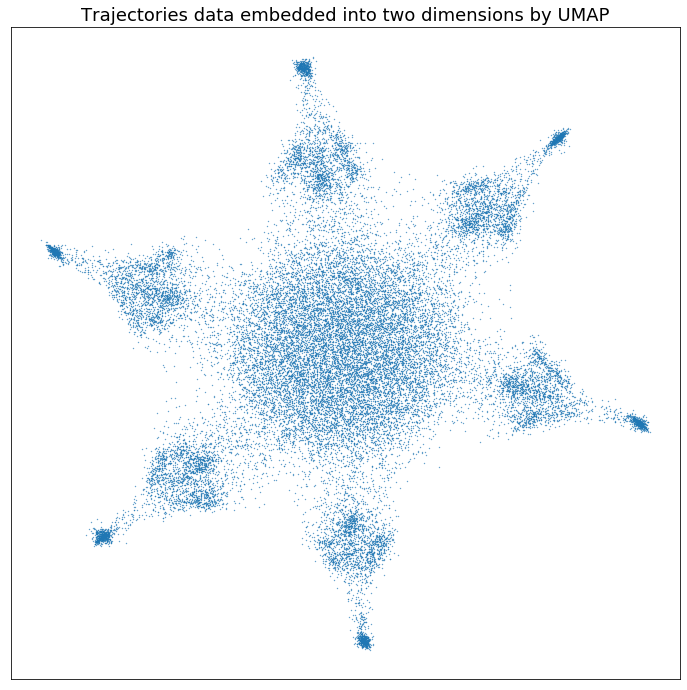

In [6]:
fig, ax = plt.subplots(figsize=(12, 12))

plt.scatter(
    embedding[:, 0], embedding[:, 1], cmap="Spectral", s=0.1
)

plt.setp(ax, xticks=[], yticks=[])
plt.title("Trajectories data embedded into two dimensions by UMAP", fontsize=18)
plt.show()

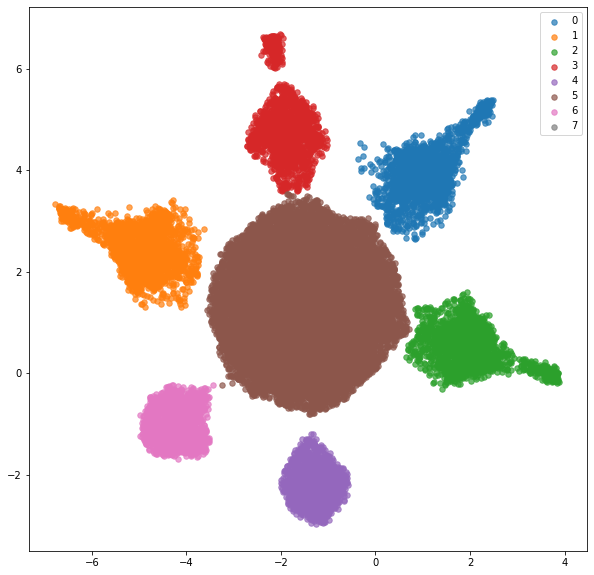

In [7]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering as kcl

Data = {'x': embedding[::,0],
        'y': embedding[::,1]
       }

df = DataFrame(Data,columns=['x','y'])

import hdbscan

labels = hdbscan.HDBSCAN(
    min_samples=100,
    min_cluster_size=750,
).fit_predict(embedding)

def plt_cls(idx):
    t = embedding[labels==idx]
    plt.scatter(t[:,0], t[:,1], alpha=0.7, s=30, label=idx)
    
plt.figure(figsize=(10,10))
labels__ = []
for i in range(len(set(labels))):
    plt_cls(i)
    labels__.append(str(i))
plt.legend(labels__)

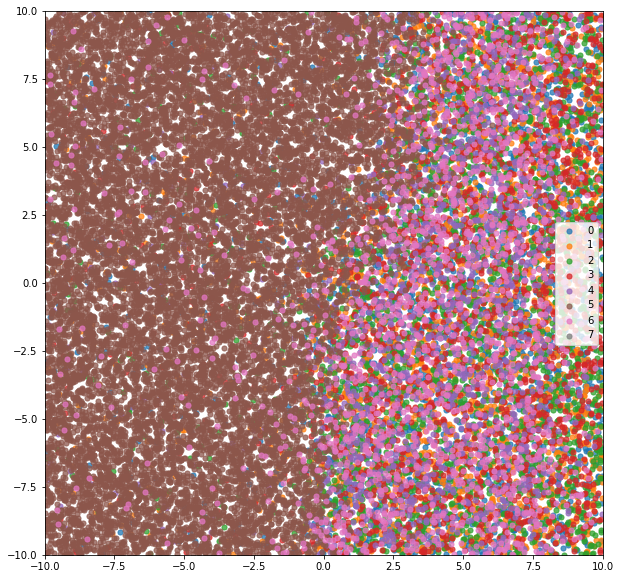

In [8]:
def plt_cls(idx):
    t = np.log(random_coords[labels==idx])
    plt.scatter(t[:,0], t[:,1], alpha=0.75, s=26, label=idx)
    
plt.figure(figsize=(10,10))
labels__ = []
for i in range(len(set(labels))):
    plt_cls(i)
    labels__.append(str(i))
plt.legend(labels__)
plt.xlim((-10,10))
plt.ylim((-10,10));

In [18]:
import umap

embedding_finite_volume_phases = umap.UMAP(verbose=True, 
                                           n_epochs=20000).fit_transform(np.cumsum(flattened_data_container[labels==5],
                                                                                   axis=1))

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=20000,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Tue Nov 12 01:14:49 2019 Finding Nearest Neighbors
Tue Nov 12 01:14:49 2019 Building RP forest with 11 trees
Tue Nov 12 01:14:50 2019 NN descent for 14 iterations


C:\deeplearning\envs\PythonGPU\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\deeplearning\envs\PythonGPU\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
Tue Nov 12 01:14:56 2019 Finished Nearest Neighbor Search
Tue Nov 12 01:14:56 2019 Construct embedding
	completed  0  /  20000 epochs
	completed  2000  /  20000 epochs
	completed  4000  /  20000 epochs
	completed  6000  /  20000 epochs
	completed  8000  /  20000 epochs
	completed  10000  /  20000 epochs
	completed  12000  /  20000 epochs
	completed  14000  /  20000 epochs
	completed  16000  /  20000 epochs
	completed  18000  /  20000 epochs
Tue Nov 12 01:34:56 2019 Finished embedding


In [64]:
np.save('embedding_finite_volume_phases', embedding_finite_volume_phases)

In [9]:
embedding_finite_volume_phases = np.load('embedding_finite_volume_phases.npy')

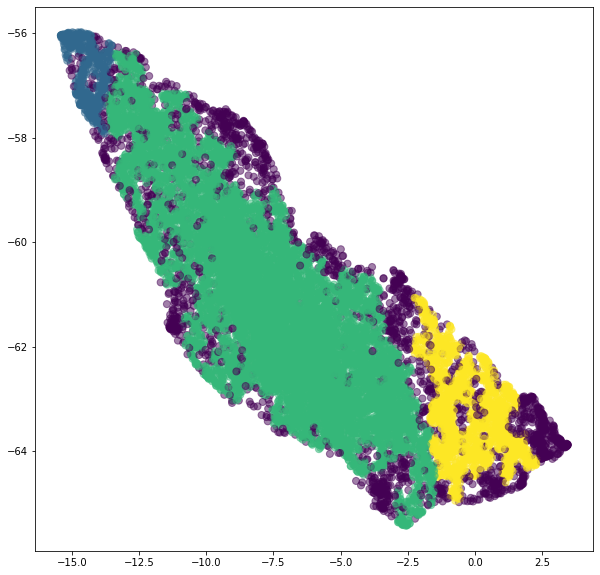

In [10]:
Data = {'x': embedding_finite_volume_phases[::,0],
        'y': embedding_finite_volume_phases[::,1]
       }

df = DataFrame(Data,columns=['x','y'])

import hdbscan

labels_finite = hdbscan.HDBSCAN(
    min_samples=4,
    min_cluster_size=250,
).fit_predict(embedding_finite_volume_phases)

plt.figure(figsize=(10,10))

plt.scatter(df['x'], df['y'], c=labels_finite, s=50, alpha=0.5, label=labels_finite)

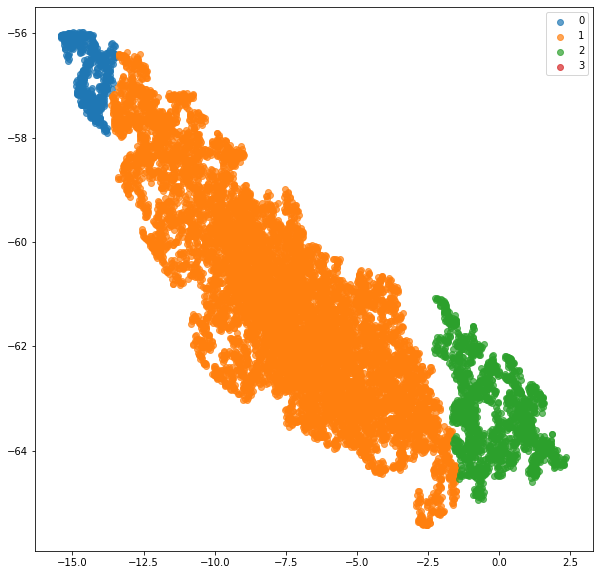

In [11]:
def plt_cls_without_0(idx):
    t = embedding_finite_volume_phases[labels_finite==idx]
    plt.scatter(t[:,0], t[:,1], alpha=0.7)
plt.figure(figsize=(10,10))
labels___ = []
for i in range(len(set(labels_finite))):
    plt_cls_without_0(i)
    labels___.append(str(i))
plt.legend(labels___)

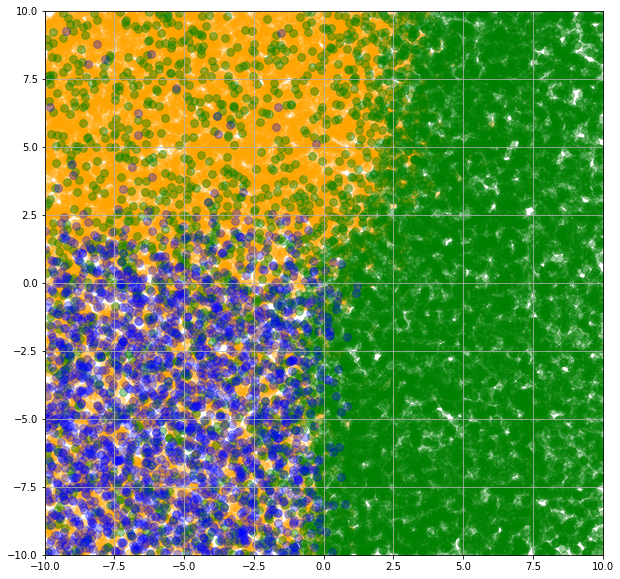

In [12]:
plt.figure(figsize=(10,10))

def plt_cls_without_0(idx):
    t = np.log(random_coords[labels==5][labels_finite==idx])
    plt.scatter(t[:,0], t[:,1], s=60, alpha=0.4, c='orange')
plt_cls_without_0(1)
plt.xlim((-10,10))
plt.ylim((-10,10))
plt.grid();
def plt_cls(idx):
    t = np.log(random_coords[:][labels==idx])
    plt.scatter(t[:,0], t[:,1], alpha=0.4, s=60, label=idx, c='green')
labels__ = []
for i in range(len(set(labels))):
    if i!=5:
        plt_cls(i)
        labels__.append(str(i))
def plt_cls_without_0(idx):
    t = np.log(random_coords[labels==5][labels_finite==idx])
    plt.scatter(t[:,0], t[:,1], s=60, alpha=0.3
                , c='blue')
plt_cls_without_0(0)
plt_cls_without_0(2)

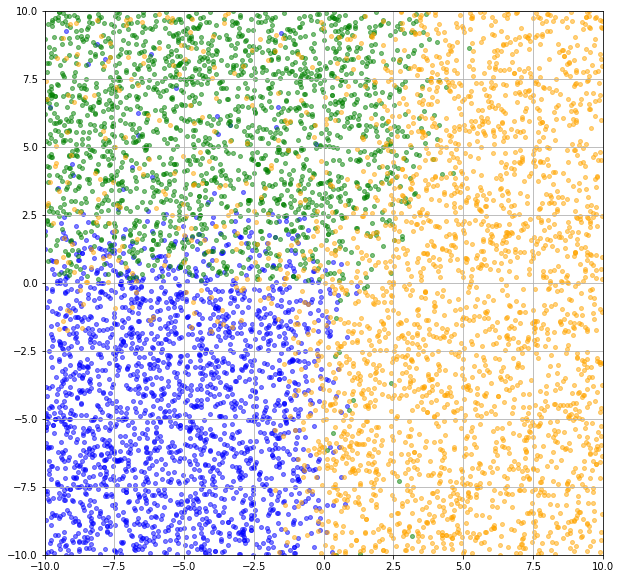

In [13]:
a1 = np.log(random_coords[labels==5][labels_finite==0])
a2 = np.log(random_coords[labels==5][labels_finite==2])
b = np.log(random_coords[labels==5][labels_finite==1])[::4]
c = np.log(random_coords[labels!=5])[::6]
a = np.r_[a1,a2]

b = b[~np.all(b<-1.2, axis=1)]
c = c[~np.all(c<-1.8, axis=1)]
b = b[np.any(b>0.1, axis=1)]

plt.figure(figsize=(10,10))
plt.grid();
plt.scatter(a[:,0], a[:,1], s=16, alpha=0.5, c='blue')
plt.scatter(b[:,0], b[:,1], s=16, alpha=0.5, c='green')
plt.scatter(c[:,0], c[:,1], s=16, alpha=0.5, c='orange')
plt.xlim((-10,10))
plt.ylim((-10,10))
plt.show();

In [161]:
LENGTH_OF_POLYMER_CHAIN = 500

a1 = np.log(random_coords[labels==5][labels_finite==0])
a2 = np.log(random_coords[labels==5][labels_finite==2])
b = np.log(random_coords[labels==5][labels_finite==1])[::4]
c = np.log(random_coords[labels!=5])[::4]
a = np.r_[a1,a2]

bbb = np.copy(b)
ccc = np.copy(c)

b = b[~np.all(b<-0.8, axis=1)]
c = c[~np.all(c<-0.8, axis=1)]



clusters_coords = np.zeros((len(a)+len(b)+len(c), 2))
clusters_coords[:len(a)] = a
clusters_coords[len(a):len(a)+len(b)] = b
clusters_coords[-len(c):] = c

clusters_labels = np.zeros(len(a)+len(b)+len(c))
clusters_labels[:len(a)] = 0
clusters_labels[len(a):len(a)+len(b)] = 1
clusters_labels[-len(c):] = 2

a1 = data_container[labels==5][labels_finite==0]
a2 = data_container[labels==5][labels_finite==2]
b = data_container[labels==5][labels_finite==1][::4]
c = data_container[:][labels!=5][::4]
a = np.r_[a1,a2]

b = b[~np.all(bbb<-0.8, axis=1)]
c = c[~np.all(ccc<-0.8, axis=1)]

clusters_labels = np.zeros(len(a)+len(b)+len(c))
clusters_labels[:len(a)] = 0
clusters_labels[len(a):len(a)+len(b)] = 1
clusters_labels[-len(c):] = 2

clusters_states = np.zeros((len(a)+len(b)+len(c), LENGTH_OF_POLYMER_CHAIN, 3))
clusters_states[:len(a)] = a
clusters_states[len(a):len(a)+len(b)] = b
clusters_states[-len(c):] = c

print(len(a), len(b), len(c))

2080 1907 3777


In [162]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(clusters_labels.reshape(-1, 1))

C:\deeplearning\envs\PythonGPU\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [171]:
X, y = (clusters_states, onehot_encoded)

for i in range(len(X)):
    X[i] = (X[i]-np.mean(X[i]))/np.std(X[i])

X.shape, y.shape

((7764, 500, 3), (7764, 3))

In [179]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras import backend as K
import keras

num_classes = 3

# input image dimensions
img_rows, img_cols = LENGTH_OF_POLYMER_CHAIN, 3

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices

model = Sequential()
model.add(Conv2D(32, kernel_size=(6, 2),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 1)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

x_train shape: (5823, 500, 3, 1)
5823 train samples
1941 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 495, 2, 32)        416       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 165, 2, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 165, 2, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 10560)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 48)                506928    
_________________________________________________________________
dropout_32 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_

In [180]:
np.save('x_train', x_train)
np.save('y_train', y_train)
np.save('x_test', x_test)
np.save('y_test', y_test)

In [181]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

In [182]:
model.fit(x_train, y_train,
          batch_size=4,
          epochs=64,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 5823 samples, validate on 1941 samples
Epoch 1/64
5823/5823 [==============================] - 10s 2ms/step - loss: 0.8143 - acc: 0.5748 - val_loss: 0.6272 - val_acc: 0.6873
Epoch 2/64
5823/5823 [==============================] - 9s 1ms/step - loss: 0.6590 - acc: 0.6555 - val_loss: 0.6010 - val_acc: 0.6873
Epoch 3/64
5823/5823 [==============================] - 9s 1ms/step - loss: 0.6541 - acc: 0.6620 - val_loss: 0.5948 - val_acc: 0.6888
Epoch 4/64
5823/5823 [==============================] - 9s 1ms/step - loss: 0.6333 - acc: 0.6665 - val_loss: 0.5865 - val_acc: 0.6950
Epoch 5/64
5823/5823 [==============================] - 9s 1ms/step - loss: 0.6333 - acc: 0.6741 - val_loss: 0.6087 - val_acc: 0.6780
Epoch 6/64
5823/5823 [==============================] - 9s 1ms/step - loss: 0.6278 - acc: 0.6899 - val_loss: 0.5887 - val_acc: 0.7439
Epoch 7/64
5823/5823 [==============================] - 9s 1ms/step - loss: 0.5879 - acc: 0.7455 - val_loss: 0.4694 - val_acc: 0.8645
Epoch 8/64
58

KeyboardInterrupt: 

In [187]:
from keras.models import load_model

model.save('my_model.h5')

In [15]:
from keras.models import load_model

model = load_model('my_model.h5')

Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
x_full = data_container.reshape(data_container.shape[0],data_container.shape[1],data_container.shape[2],1)
x_full = np.asarray(x_full, dtype=np.float32)
for i in range(len(x_full)):
    x_full[i] = (x_full[i]-np.mean(x_full[i]))/np.std(x_full[i])

In [17]:
res_test = model.predict(x_full)
predicted_labels = np.argmax(res_test, axis=1)
predicted_cluster_0 = np.log(random_coords[predicted_labels==0])
predicted_cluster_1 = np.log(random_coords[predicted_labels==1])
predicted_cluster_2 = np.log(random_coords[predicted_labels==2])

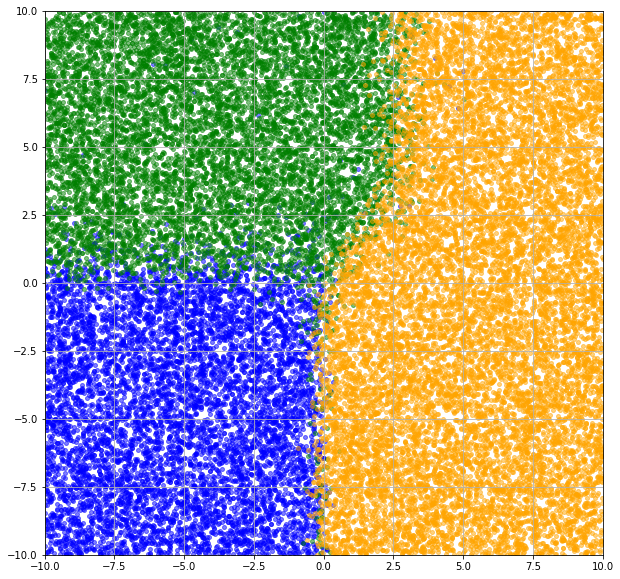

In [18]:
plt.figure(figsize=(10,10))
plt.grid();
plt.scatter(predicted_cluster_0[:,0], predicted_cluster_0[:,1], s=16, alpha=0.5, c='blue')
plt.scatter(predicted_cluster_1[:,0], predicted_cluster_1[:,1], s=16, alpha=0.5, c='green')
plt.scatter(predicted_cluster_2[:,0], predicted_cluster_2[:,1], s=16, alpha=0.5, c='orange')
plt.xlim((-10,10))
plt.ylim((-10,10))
plt.show();

## Obtain phase diagram from raw trajectories. Thermometer method.